## Import some helpful libraries

In [1]:
print("    Version control\n------------------------")
import os, fnmatch, random, math, sys, datetime
from pathlib import Path
import numpy as np;              print("Numpy\t\t", np.__version__)
import matplotlib as mpl;        print("matplotlib\t", mpl.__version__)
import matplotlib.pyplot as plt
import nibabel as nib;           print("NiBabel\t\t {}".format(nib.__version__))
from nibabel.testing import data_path
import pandas as pd;             print("Pandas\t\t {}".format(pd.__version__))
import imageio;                  print("imageio\t\t {}".format(imageio.__version__))
import h5py;                     print("H5py\t\t {}".format(h5py.__version__))
import sklearn;                  print("Scikit-learn\t {}".format(sklearn.__version__))
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
import skimage;                  print("Scikit-image\t {}".format(skimage.__version__))
import tensorflow as tf;         print("TensorFlow\t {}".format(tf.__version__))
import keras;                    print("Keras\t\t {}".format(keras.__version__))
import tensorflow.keras.backend as K
from tensorflow.keras import models, Input, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, BatchNormalization, Conv3D, MaxPooling3D, UpSampling3D, ZeroPadding3D
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.initializers import *
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.engine.topology import Layer, InputSpec
from keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from IPython.display import Image
# %load_ext tensorboard       
# %reload_ext tensorboard

    Version control
------------------------
Numpy		 1.19.4
matplotlib	 3.3.3
NiBabel		 3.2.0
Pandas		 1.1.4
imageio		 2.9.0
H5py		 2.10.0
Scikit-learn	 0.23.2
Scikit-image	 0.17.2
TensorFlow	 2.4.0
Keras		 2.4.3


## Dataset

In [421]:
## Load train data
data_source = "Data/data_random_1/" 
sample_train_subset = np.loadtxt(os.path.join(data_source, "sample_train.csv"), dtype=str, delimiter=",")
train_data = np.load(os.path.join(data_source, "train.npy")).reshape(100,182,218,182,1)
print('train_data shape is {}'.format(train_data.shape))

## Load validation data
sample_val_subset = np.loadtxt(os.path.join(data_source, "sample_valid.csv"), dtype=str, delimiter=",")
valid_data = np.load(os.path.join(data_source, "valid.npy")).reshape(24,182,218,182,1)
print('valid_data shape is {}'.format(valid_data.shape))

train_data shape is (100, 182, 218, 182, 1)
valid_data shape is (24, 182, 218, 182, 1)


In [3]:
# print("There are", len(sample_train_subset), " subset of train samples are:\n")
# print(*sample_train_subset, sep='\t')
# print("\n--------------------------------------------------------------------------------\n")
# print("There are", len(sample_val_subset), " subset of Validation samples are:\n")
# print(*sample_val_subset, sep='\t')

In [4]:
## Padding datasets
train_pad_data = (ZeroPadding3D(padding=(5,19,5))(train_data)).numpy()
print('train_padded_data shape is {}'.format(train_pad_data.shape))

valid_pad_data = (ZeroPadding3D(padding=(5,19,5))(valid_data)).numpy()
print('valid_padded_data shape is {}'.format(valid_pad_data.shape))

train_padded_data shape is (100, 192, 256, 192, 1)
valid_padded_data shape is (24, 192, 256, 192, 1)


In [5]:
## Showing slices

def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices), figsize=(10,5))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="hot", origin="upper") # hot, Greys, gray

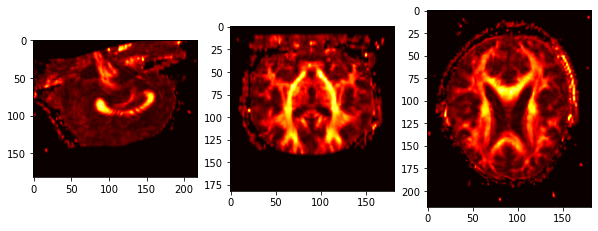

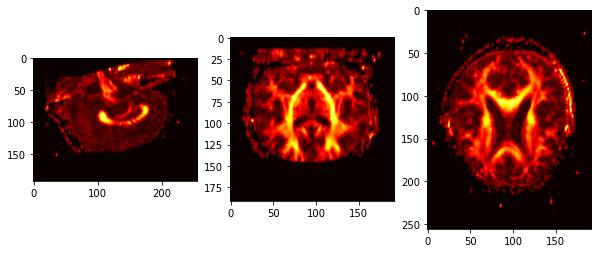

In [6]:
## Showing one or all Training samples in three dimension (one middle slice per each dimension)

for m in range(1):
    slice_0 = train_data[m, 91, :, :, 0]
    slice_1 = train_data[m, :, 109, :, 0]
    slice_2 = train_data[m, :, :, 91, 0]
    show_slices([slice_0, slice_1, slice_2])
#     plt.suptitle(sample_train_subset[m], x=0.5, y=0.9)

for m in range(1):
    slice_3 = train_pad_data[m, 96, :, :, 0]
    slice_4 = train_pad_data[m, :, 128, :, 0]
    slice_5 = train_pad_data[m, :, :, 96, 0]
    show_slices([slice_3, slice_4, slice_5])
#     plt.suptitle(sample_train_subset[m], x=0.5, y=0.9)

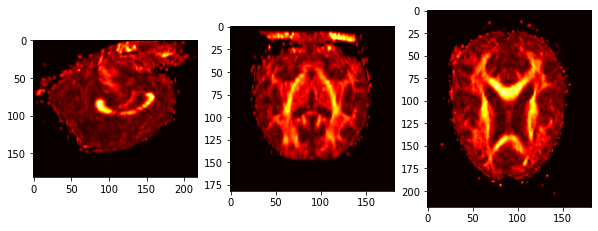

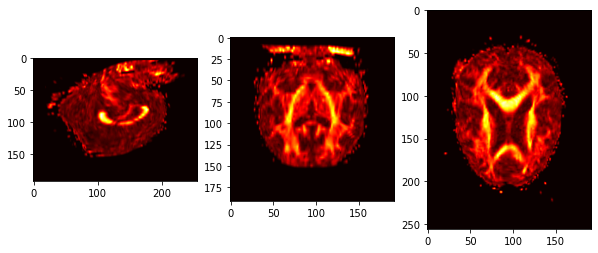

In [7]:
## Showing one or all Validation samples in three dimension (one middle slice per each dimension)

for m in range(1):
    slice_0 = valid_data[m, 91, :, :, 0]
    slice_1 = valid_data[m, :, 109, :, 0]
    slice_2 = valid_data[m, :, :, 91, 0]
    show_slices([slice_0, slice_1, slice_2])
#     plt.suptitle(sample_val_subset[m], x=0.5, y=0.9)

for m in range(1):
    slice_3 = valid_pad_data[m, 96, :, :, 0]
    slice_4 = valid_pad_data[m, :, 128, :, 0]
    slice_5 = valid_pad_data[m, :, :, 96, 0]
    show_slices([slice_3, slice_4, slice_5])
#     plt.suptitle(sample_val_subset[m], x=0.5, y=0.9)

## Model Design

In [8]:
## Convolutional AutoEncoder Model Designe:

IMAGE_HEIGHT = train_pad_data.shape[1]
IMAGE_WIDTH = train_pad_data.shape[2]
IMAGE_DEPTH = train_pad_data.shape[3]
BATCH_SIZE = 1
EPOCHS = 1
data_shape = [1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
input_shape = [BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, 1]
print("Padded data shape: {}\n".format(input_shape))

## Encoder
input_img = Input(shape=(192, 256, 192, 1), name='Input')
x = Conv3D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv1')(input_img)
x = BatchNormalization(name='BN_Conv1')(x)
x = Conv3D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv2')(x)
x = BatchNormalization(name='BN_Conv2')(x)
x = Conv3D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv3')(x)
x = BatchNormalization(name='BN_Conv3')(x)
x = Conv3D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu', name='Conv4')(x)
x = BatchNormalization(name='BN_Conv4')(x)

## Latent Features
shape_before_flattening = tf.keras.backend.int_shape(x)
x_LF = Flatten(name='LF')(x)

##____________________________________________________________________________________________________
# init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')
# # encoded = Dense(50, kernel_initializer=init, activation='relu', name='encoded')(x_LF)
# x_LF = Dense(100, activation='relu', name='encoded')(x_LF)
##____________________________________________________________________________________________________

encoded = x_LF    # Hadi for L200

##____________________________________________________________________________________________________
# x = BatchNormalization(name='BN_Dense')(encoded)
# # x = Dense(np.prod(shape_before_flattening[1:]), activation='relu', kernel_initializer=init)(encoded)
# x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(x)
# encoded = x
##____________________________________________________________________________________________________

x = Reshape(shape_before_flattening[1:], name='UnFlat')(encoded)

## Decoder
x = Conv3D(filters=16, kernel_size=3, padding='same', activation='relu', name='DeConv3')(x)
x = BatchNormalization(name='BN_DeConv3')(x)
x = UpSampling3D(size=(2, 2, 2), name='UpSampling3')(x)
x = Conv3D(filters=32, kernel_size=3, padding='same', activation='relu', name='DeConv4')(x)
x = BatchNormalization(name='BN_DeConv4')(x)
x = UpSampling3D(size=(2, 2, 2), name='UpSampling4')(x)
x = Conv3D(filters=64, kernel_size=3, padding='same', activation='relu', name='DeConv5')(x)
x = BatchNormalization(name='BN_DeConv5')(x)
x = UpSampling3D(size=(2, 2, 2), name='UpSampling5')(x)
x = Conv3D(filters=128, kernel_size=3, padding='same', activation='relu', name='DeConv6')(x)
x = BatchNormalization(name='BN_DeConv6')(x)
x = UpSampling3D(size=(2, 2, 2), name='UpSampling6')(x)
decoded = Conv3D(filters=1, kernel_size=3, padding='same', activation='sigmoid', name='Output')(x)

model_CAE = Model(inputs=input_img, outputs=decoded, name='AutoEncoder')
## optimizer=rmsprop, sgd
model_CAE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_CAE.summary()
# plot_model(model_CAE, to_file='Convolutional_autoencoder_model.png', show_shapes=True)
# Image(filename='Convolutional_autoencoder_model.png')

Padded data shape: [1, 192, 256, 192, 1]

Model: "AutoEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 192, 256, 192, 1) 0         
_________________________________________________________________
Conv1 (Conv3D)               (None, 96, 128, 96, 128)  3584      
_________________________________________________________________
BN_Conv1 (BatchNormalization (None, 96, 128, 96, 128)  512       
_________________________________________________________________
Conv2 (Conv3D)               (None, 48, 64, 48, 64)    221248    
_________________________________________________________________
BN_Conv2 (BatchNormalization (None, 48, 64, 48, 64)    256       
_________________________________________________________________
Conv3 (Conv3D)               (None, 24, 32, 24, 32)    55328     
_________________________________________________________________
BN_Conv3 (Bat

## Model Training

In [605]:
## Start time:
from datetime import datetime
start_time = datetime.now().strftime("%Y_%m_%d___%H_%M"); print("\nStart Time =", start_time, "\n")

## Model Fit
# model_CAE.load_weights(os.path.join("Weights/P4_36864___2021_01_04___08_03.hdf5"), by_name=True)  # epochs 1-50
# model_CAE.load_weights(os.path.join("Weights/P4_36864___2021_01_04___13_14.hdf5"), by_name=True)  # epochs 51_100
model_CAE.load_weights(os.path.join("Weights/P4_36864___2021_01_04___22_13.hdf5"), by_name=True)  # epochs 101_300
# model_CAE.load_weights(os.path.join("Weights/P4_36864___2021_01_05___08_50.hdf5"), by_name=True)  # epochs 301_500


# model_checkpoint_callback = ModelCheckpoint(filepath=os.path.join("Check/L1___" + start_time), save_weights_only=True, save_best_only=True, monitor='val_loss', mode='max', verbose=1) 
# tb_callback = TensorBoard(os.path.join("Logs/L1___" + start_time), histogram_freq=1)
# # early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
# # model_CAE.fit(train_data[0:10,:], train_data[0:10,:], validation_data=(valid_data, valid_data), epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, callbacks=[tb_callback, model_checkpoint_callback], verbose=1)
# model_CAE.fit(train_pad_data, train_pad_data, validation_data=(valid_pad_data, valid_pad_data), epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, callbacks=[tb_callback, model_checkpoint_callback], verbose=1)
# model_CAE.save_weights(os.path.join("Weights/L1___" + start_time + ".hdf5"))

## End time:
from datetime import datetime
end_time = datetime.now().strftime("%Y_%m_%d___%H_%M"); print("\nEnd Time =", end_time)


Start Time = 2021_01_06___05_45 


End Time = 2021_01_06___05_45


## Reconstruction

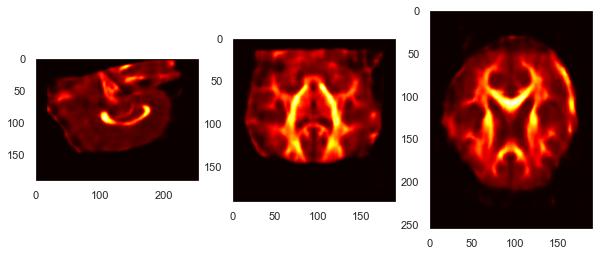

In [606]:
## Reconstructing a Train data 

test_pad_data = train_pad_data[0,:].reshape(1, 192, 256, 192, 1)
reconstructed = model_CAE.predict(test_pad_data)

for m in range(1):
    slice_0 = reconstructed[m, 96, :, :, 0]
    slice_1 = reconstructed[m, :, 128, :, 0]
    slice_2 = reconstructed[m, :, :, 96, 0]
    show_slices([slice_0, slice_1, slice_2])
#     plt.suptitle(sample_train_subset[m], x=0.5, y=0.9)

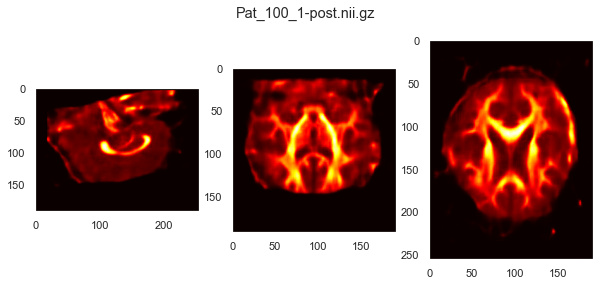

In [536]:
## Reconstructing a Train data 

# test_pad_data = train_pad_data[0,:].reshape(1, 192, 256, 192, 1)
# reconstructed = model_CAE.predict(test_pad_data)

for m in range(1):
    slice_0 = reconstructed[m, 96, :, :, 0]
    slice_1 = reconstructed[m, :, 128, :, 0]
    slice_2 = reconstructed[m, :, :, 96, 0]
    show_slices([slice_0, slice_1, slice_2])
    plt.grid(None)
    plt.suptitle(sample_train_subset[m], x=0.5, y=0.9)
    plt.grid(None)

In [11]:
# print('\ntrain_pad_data[0,100,100:105,100]\n\n {}'.format(train_pad_data[0,100,100:105,100]),'\n')
# print('\nReconstructed_data[0,100,100:105,100]\n\n {}'.format(reconstructed[0,100,100:105,100]),'\n')

## Weights

In [607]:
# ## Weights of Full-Model

# h5_file = h5py.File(os.path.join("Weights/P4_36864___2021_01_04___22_13.hdf5"), 'r')


# print(h5_file)
# Layer_size = len(list(h5_file.keys()))
# Layer_names = list(h5_file.keys())
# print("\nThere are", Layer_size, "layers in this model, named as:\n\n", Layer_names,'\n')
# print('====================================================================\n')
# for l in range(12, 13):  # Conv & Deconv (12, 23)
#     layers = h5_file[Layer_names[l]]
#     print("Layer", l+1, "-----", layers)
#     W = layers[Layer_names[l]]['kernel:0']
#     print('Layer', list(h5_file.keys())[l], '\tWeights\' shape: {}'.format(W.shape), '\n')
#     print('\nWeights[0][0][0][0][0]: {}'.format(W[0][0][0][0][0:3]))    # Weights[1][1][1][0][1]
#     print('====================================================================\n')
#     Kernel_1 = W.shape[0]
#     Kernel_2 = W.shape[1]
#     Kernel_3 = W.shape[2]
#     Kernel_all = np.zeros([Kernel_1, Kernel_2, Kernel_3])
#     for f in range(W.shape[4]):   # W.shape[4]
#         for x in range(Kernel_1):
#             for y in range(Kernel_2):
#                 for z in range(Kernel_3):
#                     Kernel_all[x][y][z] = W[x][y][z][0][f]
# #         print('\nWeights of kernel', f+1, 'of', W.shape[4], ':\n\n', Kernel_all)

## LF features

In [608]:
model_Encoder = Model(inputs=input_img, outputs=encoded, name='Encoder')
model_Encoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# model_Encoder.summary()
# plot_model(model_Encoder, to_file='Encoder_model.png', show_shapes=True)
# Image(filename='Encoder_model.png')

In [609]:
test_pad_data = train_pad_data[0,:].reshape(1, 192, 256, 192, 1)
LF_features = model_Encoder.predict(test_pad_data)[0]

print('LF_features size: {} -------- {} \n'.format(LF_features.shape, type(LF_features)))
print('The first feature is {}\n'.format(LF_features[0]))
print(LF_features)

LF_features size: (36864,) -------- <class 'numpy.ndarray'> 

The first feature is -0.28968334197998047

[-0.28968334 -0.08131942 -1.0805163  ... -0.363689   -0.69987214
 -0.61127096]


In [1]:
LLL = LF_features.reshape(12,16,12,16)
print(LLL.shape)   #(1, 192, 256, 192, 1)
for m in range(16):
    slice_0 = LLL[0, :, :, m]
    slice_1 = LLL[1, :, :, m]
    slice_2 = LLL[2, :, :, m]
    show_slices([slice_0, slice_1, slice_2])

NameError: name 'LF_features' is not defined

In [611]:
# tensorboard --logdir=Logs       ## http://localhost:6006/

In [618]:
## Produce a LF matrix as numpy array

# a = []
# for p in range (len(val_name)):
#     test_pad_data = valid_pad_data[p,:].reshape(1, 192, 256, 192, 1)
#     LF_features = model_Encoder.predict(test_pad_data)[0]
#     a.append(LF_features)
# #     print(p)
# for p in range (len(train_name)):
#     test_pad_data = train_pad_data[p,:].reshape(1, 192, 256, 192, 1)
#     LF_features = model_Encoder.predict(test_pad_data)[0]
#     a.append(LF_features)
# #     print(p)

# LF_matrix = np.array(a)
# # print(LF_matrix.shape)
# # print(type(LF_matrix))
# # np.save('LF_e300', LF_matrix)
# np.save('LF_e500', LF_matrix)

In [659]:
## Produce a LF matrix

rows = []
val_name = sample_val_subset
train_name = sample_train_subset

In [665]:
# for p in range (len(val_name)):
#     Pat_name = val_name[:][p]
#     if Pat_name[7] == '_':
#         Pat_name = Pat_name[0:9] + '_post'
#     elif Pat_name[6] == '_':
#         Pat_name = Pat_name[0:4] + '0' + Pat_name[4:8] + '_post'
#     else:
#         Pat_name = Pat_name[0:4] + '00' + Pat_name[4:7] + '_post'
#     rows.append([Pat_name])

# for p in range (len(train_name)):
#     Pat_name = train_name[:][p]
#     if Pat_name[7] == '_':
#         Pat_name = Pat_name[0:9] + '_post'
#     elif Pat_name[6] == '_':
#         Pat_name = Pat_name[0:4] + '0' + Pat_name[4:8] + '_post'
#     else:
#         Pat_name = Pat_name[0:4] + '00' + Pat_name[4:7] + '_post'
#     rows.append([Pat_name])
# rows

In [720]:
# LF_matrix = np.load('LF_e300.npy')
LF_matrix = np.load('LF_e500.npy')

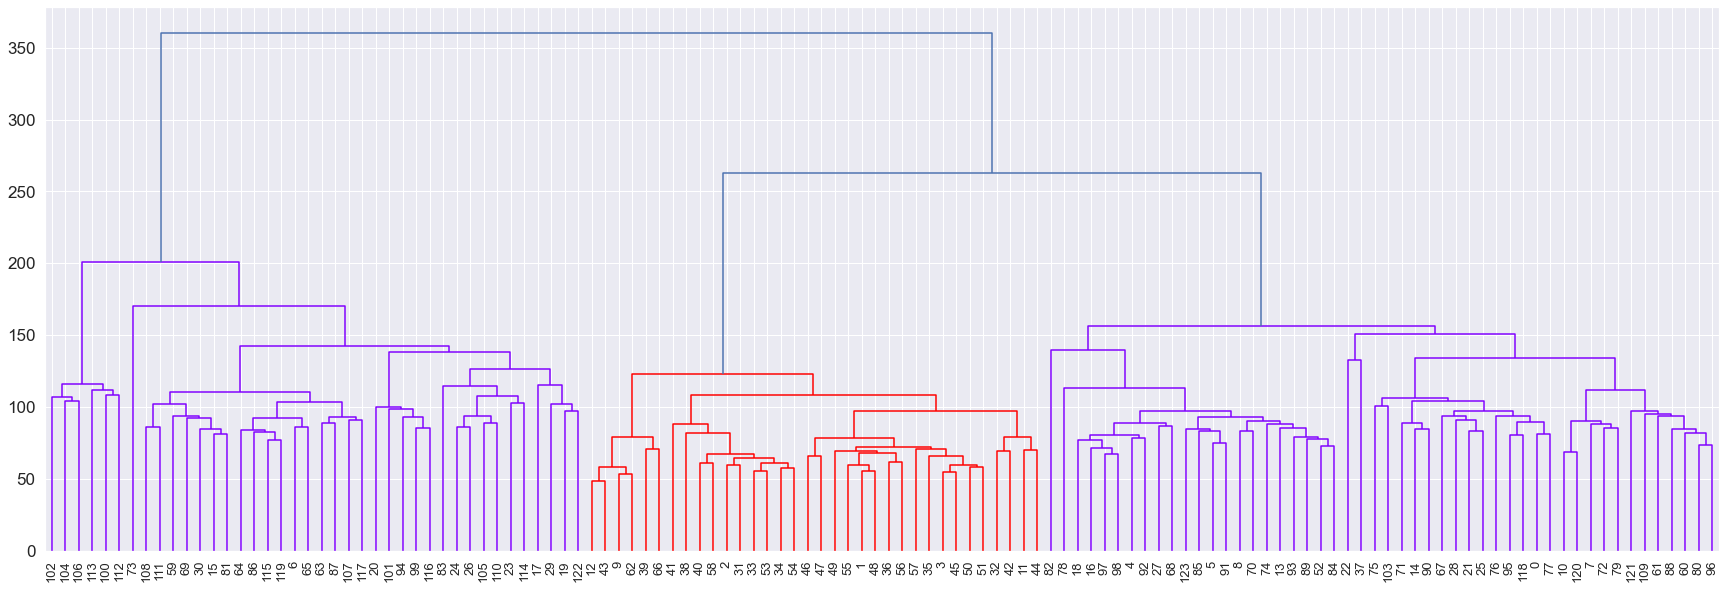

In [729]:
## Hierarchical Clustering

from matplotlib.pyplot import cm
plt.figure(figsize=(30, 10))
plt.grid()
linked = linkage(LF_matrix, method='ward', metric='euclidean')   # ward , single , complete , weighted, average , centroid
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)  # descending
cmap = cm.rainbow(np.linspace(0, 1, 2))
hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])
# hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=13)
ax.tick_params(axis='y', which='major', labelsize=17)
plt.show()
# grid(b= bool, color='r', linestyle='-', linewidth=2)

In [722]:
## K-Means Clustering

print(LF_matrix.shape, '\n')
kmeans = KMeans(n_clusters=4, random_state=0).fit(LF_matrix)
cluster_labels = kmeans.labels_
print(cluster_labels, '\n\n\n')

cluster_predict = kmeans.predict(LF_matrix[:])
# print(cluster_predict, '\n\n\n')

cluster_center = kmeans.cluster_centers_
# print(cluster_center.shape, '\n\n', cluster_center)

(124, 36864) 

[1 2 2 2 1 1 1 1 1 2 2 2 2 1 1 0 1 0 1 3 0 1 0 1 0 1 0 1 1 0 0 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 0 1 1 2 1 1 0 1 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 3 0 3 1 3 0 3 0 0 1 0
 0 3 0 0 0 0 0 1 1 2 1 3 1] 





In [711]:
## make a dataframe of patient names
# for p in range(124):
# #     rows[p].append(cluster_labels[p])    # e300
# #     rows[p].append(cluster_labels[p])    # e500
#     rows[p].append(0)    # e500
# rows

In [719]:
# df = pd.DataFrame(rows, columns=["Pat_name", "class_e300", "class_e500", "cluster_changed"])
# print(df)
# df['class_e500'][df['class_e500'] == 2] = 7
# df['class_e500'][df['class_e500'] == 0] = 2
# df['class_e500'][df['class_e500'] == 7] = 0
# df['cluster_changed'][df['class_e300'] != df['class_e500']] = 1
# print(df)
# df.index = df[df.columns[0]]
# df = df.drop(['Pat_name'], axis=1)
# df = df.sort_index()
# df.to_csv(r'Pat_Class.csv', index = True)
# print('There are {} patients with different clusters in more epochs training!'.format(df['cluster_changed'].sum()))
# df
df = pd.read_csv('Pat_Class.csv')
df.index = df[df.columns[0]]
df = df.drop(['Pat_name'], axis=1)
# df = df.drop(['cluster_changed'], axis=1)
df

,class_e300,class_e500
Pat_name,,
Pat_001_1_post,1,1
Pat_002_1_post,2,0
Pat_003_1_post,2,1
Pat_004_1_post,0,0
Pat_005_1_post,1,1
...,...,...
Pat_141_1_post,0,0
Pat_142_1_post,0,0
Pat_143_1_post,0,0


LF_matrix shape (124, 36864)


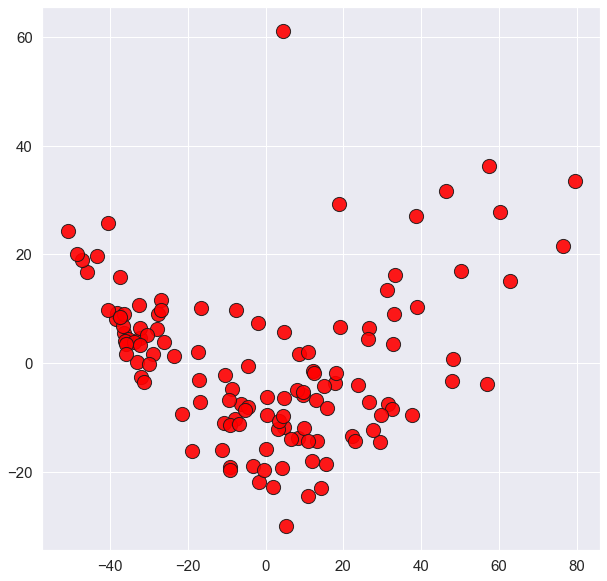

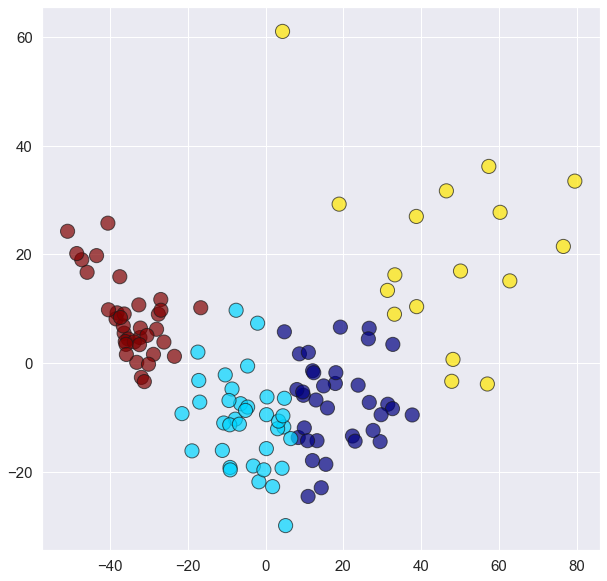

In [723]:
## PCA >>> Scatter plot >>> K-means Clustering

plt.figure(figsize=(10, 10))
plt.grid()
print('LF_matrix shape {}'.format(LF_matrix.shape))
pca = PCA(n_components=2)
pca.fit(LF_matrix)
LF_matrix_pca = pca.transform(LF_matrix)
plt.scatter(LF_matrix_pca[:,0], LF_matrix_pca[:,1], s=200, c='red', edgecolors='k', alpha=0.9)
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.show()

kmeans = KMeans(n_clusters=4)
kmeans.fit(LF_matrix_pca)
y_kmeans = kmeans.predict(LF_matrix_pca)
plt.figure(figsize=(10, 10))
plt.grid()
plt.scatter(LF_matrix_pca[:,0], LF_matrix_pca[:,1], c=y_kmeans, s=200, cmap='jet', edgecolors='k', alpha=0.7)
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.show()

Automatically created module for IPython interactive environment
Estimated number of clusters: 3
Estimated number of noise points: 18
Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.916
Silhouette Coefficient: 0.626


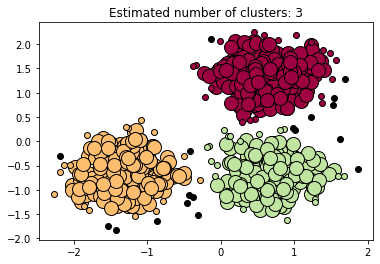

In [38]:
## DBSCAN Clustering

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4, random_state=0)
X = StandardScaler().fit_transform(X)
# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()